In [3]:
!pip install pyspark pandas seaborn plotly joblib sympy

  Using cached pyspark-3.5.3.tar.gz (317.3 MB)
  Preparing metadata (setup.py) ... done
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=58cf0a492d7c279b280900bcda05493b9874f678dcda0272b129a15623cd21ab
  Stored in directory: /Users/chenjieliu/Library/Caches/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


## 1. Recommendation System with LSH
In this section, you will implement a recommendation system by identifying users with similar preferences and suggesting movies based on their behavior. Specifically, you will implement your version of the LSH algorithm.
### 1.1 Data Preparation
Download the MovieLens dataset from here. After downloading, explore the dataset to understand the structure and identify any preprocessing steps needed.

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from MinHash import *
from joblib import Parallel, delayed

Reading the datasets

In [3]:
genome_scores_df=pd.read_csv('./data/genome_scores.csv')
genome_tags_df=pd.read_csv('./data/genome_tags.csv')
link_df=pd.read_csv('./data/link.csv')
movie_df=pd.read_csv('./data/movie.csv')
rating_df=pd.read_csv('./data/rating.csv')
tag_df=pd.read_csv('./data/tag.csv')

Exploring the datasets by displaying their heads, the number of NaN values in each column, the number of distinct values in each column, the number of records in each column and the number of duplicated records.

In [4]:
print("Dataset Genome Score")
display(genome_scores_df.head())
print("Genome Score number of NaN")
display(genome_scores_df.isna().sum())
print("Genome Score number of distinct values")
display(genome_scores_df.nunique())
print("Genome Score number of rows")
print(genome_scores_df.count())
print("Genome Score duplicated rows")
print(genome_scores_df.duplicated().sum())

print("Dataset Genome Tags")
display(genome_tags_df)
print("Genome Tags number of NaN")
display(genome_tags_df.isna().sum())
print("Genome Tags number of distinct values")
display(genome_tags_df.nunique())
print("Genome Tags number of rows")
print(genome_tags_df.count())
print("Genome Tags duplicated rows")
print(genome_tags_df.duplicated().sum())

print("Dataset Link")
display(link_df.head())
print("Link number of NaN")
display(link_df.isna().sum())
print("Link number of distinct values")
display(link_df.nunique())
print("Link number of rows")
print(link_df.count())
print("Link duplicated rows")
print(link_df.duplicated().sum())

print("Dataset Movie")
display(movie_df.head())
print("Movie number of NaN")
display(movie_df.isna().sum())
print("Movie number of distinct values")
display(movie_df.nunique())
print("Movie number of rows")
print(movie_df.count())
print("Movie duplicated rows")
print(movie_df.duplicated().sum())

print("Dataset Rating")
display(rating_df.head())
print("Rating number of NaN")
display(rating_df.isna().sum())
print("Rating number of distinct values")
display(rating_df.nunique())
print("Rating number of rows")
print(rating_df.count())
print("Rating duplicated rows")
print(rating_df.duplicated().sum())

print("Dataset Tag")
display(tag_df.head())
print("Tag number of NaN")
display(tag_df.isna().sum())
print("Tag number of distinct values")
display(tag_df.nunique())
print("Tag number of rows")
print(tag_df.count())
print("Tag duplicated rows")
print(tag_df.duplicated().sum())



Dataset Genome Score


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


Genome Score number of NaN


movieId      0
tagId        0
relevance    0
dtype: int64

Genome Score number of distinct values


movieId      10381
tagId         1128
relevance     4000
dtype: int64

Genome Score number of rows
movieId      11709768
tagId        11709768
relevance    11709768
dtype: int64
Genome Score duplicated rows
0
Dataset Genome Tags


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


Genome Tags number of NaN


tagId    0
tag      0
dtype: int64

Genome Tags number of distinct values


tagId    1128
tag      1128
dtype: int64

Genome Tags number of rows
tagId    1128
tag      1128
dtype: int64
Genome Tags duplicated rows
0
Dataset Link


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Link number of NaN


movieId      0
imdbId       0
tmdbId     252
dtype: int64

Link number of distinct values


movieId    27278
imdbId     27278
tmdbId     27008
dtype: int64

Link number of rows
movieId    27278
imdbId     27278
tmdbId     27026
dtype: int64
Link duplicated rows
0
Dataset Movie


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Movie number of NaN


movieId    0
title      0
genres     0
dtype: int64

Movie number of distinct values


movieId    27278
title      27262
genres      1342
dtype: int64

Movie number of rows
movieId    27278
title      27278
genres     27278
dtype: int64
Movie duplicated rows
0
Dataset Rating


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


Rating number of NaN


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Rating number of distinct values


userId         138493
movieId         26744
rating             10
timestamp    15351121
dtype: int64

Rating number of rows
userId       20000263
movieId      20000263
rating       20000263
timestamp    20000263
dtype: int64
Rating duplicated rows
0
Dataset Tag


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


Tag number of NaN


userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

Tag number of distinct values


userId         7801
movieId       19545
tag           38643
timestamp    425373
dtype: int64

Tag number of rows
userId       465564
movieId      465564
tag          465548
timestamp    465564
dtype: int64
Tag duplicated rows
0


From the previous analysis, we can observe several useful insights about these datasets:

- We have determined the dimensions of each dataset.
- We know the number of rows in each dataset.
- The datasets include 1,128 distinct tags, 27,278 registered movies, and 138,493 users who have rated at least one movie.
- Most of the data is categorical, except for the relevance values and rating scores, which are numerical.
- We know there are no duplicated rows across all datasets.
- There are almost no null values across all datasets, except for a few cases in the Link and Tag datasets. In the Link dataset, these missing values can be explained by data not being entered during input. As such, they do not compromise the validity of the records. However, in the Tag dataset, which is supposed to contain tags registered by users, a record becomes insignificant if the Tag value is None. For this reason, we will drop the records with null values in the Tag column of the Tag dataset.

In [5]:
tag_df = tag_df.dropna(subset=['tag'])

In addition, we noticed that the movie genres in the movie dataset are separated by '|'. We will split these genres and store them as a list to simplify potential future usage. Afterward, we will print all the unique genres present in the dataset.

In [6]:
movie_df['genres']=movie_df['genres'].apply(lambda x: x.split('|'))
distinct_genre_values = set(value for genre in movie_df['genres'] for value in genre)
print(distinct_genre_values)

{'Animation', 'Comedy', 'Musical', 'Horror', 'IMAX', 'War', 'Documentary', 'Mystery', 'Adventure', 'Children', 'Thriller', 'Romance', 'Fantasy', 'Western', '(no genres listed)', 'Action', 'Sci-Fi', 'Drama', 'Crime', 'Film-Noir'}


As observed in the previously printed list of genres, there is an interesting value: (no genres listed). This value indicates that some movies have not been categorized into any genre. To avoid potential discrepancies in the future, we will remove this value from the genre list.

In [7]:
movie_df['genres']=movie_df['genres'].apply(lambda x:  [item for item in x if item != '(no genres listed)'])
distinct_genre_values = set(value for genre in movie_df['genres'] for value in genre)
print(distinct_genre_values)

{'Animation', 'Comedy', 'Musical', 'Horror', 'IMAX', 'War', 'Documentary', 'Mystery', 'Adventure', 'Children', 'Thriller', 'Romance', 'Fantasy', 'Western', 'Action', 'Sci-Fi', 'Drama', 'Crime', 'Film-Noir'}


It is a good pratice displaying the distribution of rating value, in order to understand what what is its value range.

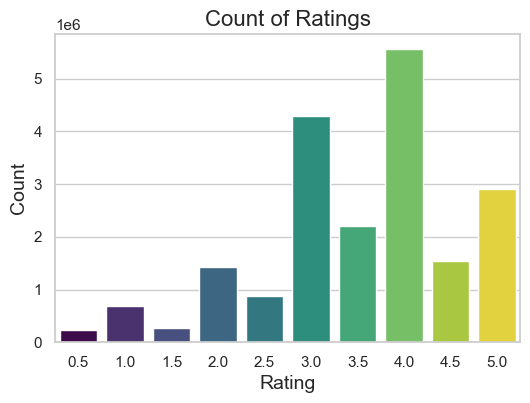

In [8]:
sns.set_theme(style='whitegrid')
rating_counts = rating_df['rating'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, hue=rating_counts.index,palette='viridis',legend=False)
plt.title('Count of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.show()

The important point to note is that the rating values range from 0.5 to 5.0, with 3.0 and 4.0 being the most common ratings.

Additionally, both the Tag and Rating datasets have a timestamp column. It is also a good practice to visualize when the tags and ratings were submitted.

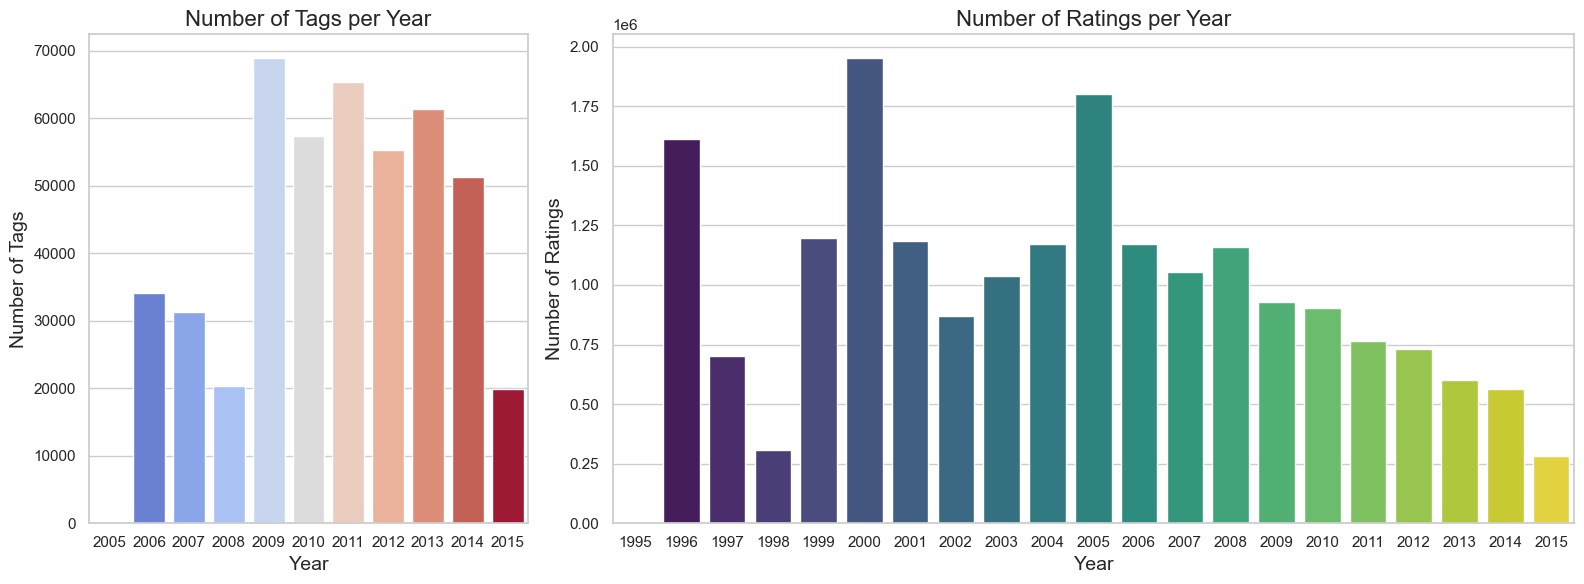

In [9]:
tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'])
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'], errors='coerce')

#Count the number of records for each year
tag_year_counts = tag_df['timestamp'].dt.year.value_counts().sort_index()
rating_year_counts = rating_df['timestamp'].dt.year.value_counts().sort_index()

fig = plt.figure(figsize=(16, 6))


ax1 = fig.add_subplot(1, 3, 1)#Occupies 1/3 of the width
sns.barplot(
    x=tag_year_counts.index,
    y=tag_year_counts.values,
    hue=tag_year_counts.index,
    legend=False,
    palette='coolwarm',
    ax=ax1
)
ax1.set_title('Number of Tags per Year', fontsize=16)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Number of Tags', fontsize=14)

ax2 = fig.add_subplot(1, 3, (2, 3))#Occupies 2/3 of the width
sns.barplot(
    x=rating_year_counts.index.astype(int), 
    
    y=rating_year_counts.values,
    hue=rating_year_counts.index.astype(int),
    legend=False,
    palette='viridis',
    ax=ax2
)
ax2.set_title('Number of Ratings per Year', fontsize=16)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel('Number of Ratings', fontsize=14)


plt.tight_layout()
plt.show()


As shown in the previous two plots:
- The tag submission timestamps range from 2005 to 2015.
- In contrast, ratings were submitted between 1995 and 2015.

We then merge the Movie, Rating, and Link datasets into a single unified dataset. Similarly, we combine the Genome Score and Genome Tag datasets, as they are related by specific keys. This "join" operation consolidates multiple datasets without introducing any additional records. Herein, the final datasets that we will use in this homework are <strong>user_rating</strong>, <strong>tag_relevance</strong>, and <strong>tag</strong>.

In [10]:
user_rating_df = pd.merge(movie_df, rating_df, on='movieId', how='inner')
user_rating_df = pd.merge(user_rating_df, link_df, on='movieId', how='inner') 
tag_relevance_df = pd.merge(genome_scores_df, genome_tags_df, on='tagId', how='left') 

display(user_rating_df)
display(tag_relevance_df)
display(tag_df)

,movieId,title,genres,userId,rating,timestamp,imdbId,tmdbId
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3,4.0,1999-12-11 13:36:47,114709,862.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",6,5.0,1997-03-13 17:50:52,114709,862.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",8,4.0,1996-06-05 13:37:51,114709,862.0
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",10,4.0,1999-11-25 02:44:47,114709,862.0
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",11,4.5,2009-01-02 01:13:41,114709,862.0
...,...,...,...,...,...,...,...,...
20000258,131254,Kein Bund für's Leben (2007),[Comedy],79570,4.0,2015-03-30 19:32:59,466713,4436.0
20000259,131256,"Feuer, Eis & Dosenbier (2002)",[Comedy],79570,4.0,2015-03-30 19:48:08,277703,9274.0
20000260,131258,The Pirates (2014),[Adventure],28906,2.5,2015-03-30 19:56:32,3485166,285213.0
20000261,131260,Rentun Ruusu (2001),[],65409,3.0,2015-03-30 19:57:46,249110,32099.0


,movieId,tagId,relevance,tag
0,1,1,0.02500,007
1,1,2,0.02500,007 (series)
2,1,3,0.05775,18th century
3,1,4,0.09675,1920s
4,1,5,0.14675,1930s
...,...,...,...,...
11709763,131170,1124,0.58775,writing
11709764,131170,1125,0.01075,wuxia
11709765,131170,1126,0.01575,wwii
11709766,131170,1127,0.11450,zombie


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18
...,...,...,...,...
465559,138446,55999,dragged,2013-01-23 23:29:32
465560,138446,55999,Jason Bateman,2013-01-23 23:29:38
465561,138446,55999,quirky,2013-01-23 23:29:38
465562,138446,55999,sad,2013-01-23 23:29:32


### 1.2 Minhash Signatures
Using the userId and movieId columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

- Important: Implement your MinHash function from scratch—do not use any pre-built hash functions.
- Use your MinHash function to generate signature vectors for each user based on their rated movies.
- Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.
- Read the class materials and, if necessary, conduct an internet search. The description of hash functions in the book may be helpful as a reference.

Group the movies watched by each user

In [11]:
user_movies = user_rating_df.groupby("userId")["movieId"].apply(list).to_dict()
max_userid = len(user_movies)

Create MinHash Signature for each user by iterating through user's watched movie list and applying the hash functions<br>
For each user's movie list we compute the MinHash Signature based on the chosen hash method

In [23]:
num_hashes = 50 
minhash = MinHash(max_val=max_userid,num_hashes=num_hashes)
results = Parallel(n_jobs=-1)(
    delayed(lambda user_id, movies: (user_id, minhash.generate_signature(movies)))(user_id, movies)
    for user_id, movies in user_movies.items()
)
user_signatures = {user: sig for user, sig in results}


Compare the target user's signature vectors with those of all other users, and register users whose similarity exceeds the threshold.

In [24]:
def find_similar_users(target_user_idx, value_list, threshold):
    similar_users = []
    target_value = value_list[target_user_idx]
    
    for idx, list in value_list.items():
        if idx == target_user_idx:
            continue
        # Calculate similarity
        similarity = minhash.signature_similarity(target_value, list)
        real_similarity=float(f"{minhash.jaccard_similarity(set(target_value),set( list)):.2f}")
        # Filter based on threshold
        if similarity >= threshold:
            similar_users.append((idx, similarity,real_similarity))

    return similar_users

Experimenting with different hash functions and threshold values, specifically, we are going to test and observe how the difference between the real similarity and estimated Jaccard similarity varies within those parameters.<br>
The parameters include 3 hash functions with different random coefficients, (a * x + b) % prime, (2 * a * x + b) % prime, and (3 * a * x + b) % prime, 9 thresholds from 0.1 to 0.9 with a scale of 0.1.<br>
The configurations are performed on 5 users, so we get more samples to observe.

In [ ]:
#It will take more than 10 minutes
# Define the range of thresholds to experiment with
thresholds = [x/10 for x in range(1,10,1)]
target_user_idxs = [1,2,3,4,5] 
hash_methods=[(1,'(a * x + b) % prime'),(2,'(2 * a * x + b) % prime'),(3,'(3 * a * x + b) % prime')]
num_hashes = 50 
minhash = MinHash(max_val=max_userid,num_hashes=num_hashes)
for target_user_idx in target_user_idxs:
    print(f"User: {target_user_idx}")

    for hm,function in hash_methods:
        print(f"Hash method: {function}")

        print("Generating user signatures")
        results = Parallel(n_jobs=-1)(
        delayed(lambda user_id, movies: (user_id, minhash.generate_signature(movies,hm)))(user_id, movies)
        for user_id, movies in user_movies.items()
        )
        user_signatures = {user: sig for user, sig in results}
        print("User signature generated")
        # Loop through each threshold and find similar users
        for threshold in thresholds:        
            similar_users = find_similar_users(target_user_idx, user_signatures, threshold)
            similar_users.sort()
            print(f"\nThreshold: {threshold}. Number of matched users: {len(similar_users)}")
            if(len(similar_users)>0):
                print("Info in tuples: (UserID, hash function similarity, real similarity)")
                print(f"Users similar to user {target_user_idx} (Threshold: {threshold}): {similar_users[:20]}")
                similar_users = np.array(similar_users)
                print(f"Average error: {np.mean(abs(similar_users[:,2]-similar_users[:,1])):.2f}")




The average error of each test represents the mean of the similarity differences.
From the test results, we can observe that changing the coefficients does not improve the efficiency of the estimation. Furthermore, at least in the tested scenario, no users have a similarity score higher than 0.5 (or 50%). Most importantly, the average estimation error is lowest when the threshold is set to 0.1. Based on these findings, we will retain (a⋅x+b)%prime as the hash function and 0.1 as the threshold.

### 1.3 Locality-Sensitive Hashing (LSH)
Now that you have generated MinHash user signatures, apply Locality-Sensitive Hashing (LSH) to cluster similar users.

- Bucket Creation: For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.

    - Debugging Tip: After creating buckets, check a few bucket contents to verify that multiple users are being grouped in the same buckets.
- Query: For a given user, identify the two most similar users based on their bucket placement. If a user doesn’t have any similar users in their bucket, adjust the parameters until similar users are found.

- Movie Recommendation Logic:
    - If both similar users have rated a movie, recommend this movie based on the average rating.
    - If there are no commonly rated movies, recommend the top-rated movies of the most similar user.
- Final Recommendation: Provide at most five movies to the user.

Example recommendation logic for a user:

| **User** | **Movie Title** | **Rating** |
|----------|-----------------|------------|
| A        | Inception       | 4.5        |
| A        | Titanic         | 4.2        |
| A        | Avatar          | 2.8        |
| B        | Inception       | 4.6        |
| B        | The Matrix      | 3.9        |
| B        | Toy Story       | 4.7        |
| C        | Titanic         | 3.8        |
| C        | Avatar          | 4.3        |
| C        | Shrek           | 4.1        |

If User A and User B are identified as the two most similar users to User X, the recommended movies would be:

- Common Movies: "Inception" (average rating: 4.55).
- Top-rated from Most Similar User: "Toy Story" (4.7) from User B and "Titanic" (4.2) from User A.
- If fewer than 5 movies are found, complete the list using other high-rated movies by the most similar users.

## 2. Grouping Movies Together!
In this section, you will explore clustering algorithms to group the movies you have based on specific features you choose to consider for them.
### 2.1 Feature Engineering
As you know, the dataset provided isn’t particularly clean or well-structured to represent the features of the movies. Therefore, your first step is to create a more suitable set of attributes (variables, features, covariates) to represent the movies based on the available information. Here are some variables or features you might consider for clustering:

- `movieid` id of each movie
- `genres` list of genres attached to the movie (given that a movie may have several genres, it’s essential to devise a method to accurately represent the genres for each movie)
- `ratings_avg` the average ratings provided by users for the movie
- `relevant_genome_tag` the most relevant tag to the movie given in the genome set
- `common_user_tag` the most common tag given to the movie by the users  


In addition to the above features, include at least three additional features for clustering.

Note: If you have accurately identified and applied the methods for representing the features, you should have more than eight features! How could this happen? Take a moment to think about it.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
spark = SparkSession.builder.appName("MovieLens Feature Engineering").getOrCreate()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# reading the CSVs
ratings = spark.read.csv('./data/rating.csv', header=True, inferSchema=True)
movies = spark.read.csv('./data/movie.csv', header=True, inferSchema=True)
tags = spark.read.csv('./data/tag.csv', header=True, inferSchema=True)
genome_scores = spark.read.csv('./data/genome_scores.csv', header=True, inferSchema=True)
genome_tags = spark.read.csv('./data/genome_tags.csv', header=True, inferSchema=True)

#2.1 FEATURE ENGENEERING

# Splitting genres column by "|", if there is more than one genre to describe a film
movies = movies.withColumn("genres_list", F.split(F.col("genres"), "\|"))

# Creation of a new column every time there is a new genre in the column "genres"
unique_genres = movies.select(F.explode(F.col("genres_list")).alias("genre")).distinct().rdd.flatMap(lambda x: x).collect()

# attributing 1 if the film has a genre, 0 if not
for genre in unique_genres:
    movies = movies.withColumn(genre, F.array_contains(F.col("genres_list"), genre).cast("int"))

# calculating the average of the ratings for every film and creating a column to save this attribute
ratings_summary = ratings.groupBy("movieId").agg(
    F.round(F.avg("rating"), 3).alias("ratings_avg"),  
    F.count("rating").alias("total_ratings")        
)

# joining the scores of the tag to the names
genome = genome_scores.join(genome_tags, "tagId", "inner")

#computing the maximum relevance for a tag for every movie in the dataframe
genomemaxrel = genome.withColumn(
    "max_relevance", #we create a new column, named max_relevance
    F.max("relevance").over(Window.partitionBy("movieId")) #we use the tool of window partition to compute the max operation for each movie separately 
)

#Filter to keep the tags for each film with the maximum relevance
relevant_tag = genomemaxrel.filter(
    F.col("relevance") == F.col("max_relevance") #filtering the rows to maintain only the rows with maximum relevance
).select(
    "movieId", #apply this filter to each film, to have only one row per movie
    F.col("tag").alias("relevant_tag") #renaming the column using the alias function, to be sure that this value does not overwrite the original value in tag column
)

#Count every time a tag appears for any movie
tags = tags.groupBy("movieId", "tag").count()

#Creating a descending rank for the tags of every film, to make it easy to catch the most common tag in any film
tagrank = tags.withColumn(
    "rank",
    F.row_number().over(Window.partitionBy("movieId").orderBy(F.desc("count")))
)

#Filtering the tags to have as output the most common tag for each film
common_tag = tagrank.filter(
    F.col("rank") == 1
).select(
    "movieId",
    F.col("tag").alias("common_tag")
)

# joining the movies dataframe with the variables about ratings and tags
df = movies.join(ratings_summary, "movieId", "left") \
    .join(relevant_tag, "movieId", "left") \
    .join(common_tag, "movieId", "left")

#We extract the title from the whole title column, which comprehends also the year of the movie
df = df.withColumn(
    "titlefilm", 
    F.regexp_extract(F.col("title"), r'^(.*) \(\d{4}\)', 1)  #Using the regex to extract the text
)

# Extracting the year of the film from the whole title column
df = df.withColumn(
    "year", 
    F.regexp_extract(F.col("title"), r'\((\d{4})\)', 1).cast("int")  #Using the regex to extract the year of the film
)

#dropping genres and genres_list, because it would be a repetition of the single columns
df = df.drop("genres", "genres_list", "title", "(no genres listed)")

# dropping duplicates that can occur with movieId(some typos)
df = df.dropDuplicates(["movieId"])

# ordering the dataframe by movieId
df = df.orderBy("movieId")

df.show(10)


+-------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+----+------+-------+------+--------+------+------+-----------+-------------+------------+--------------------+--------------------+----+
|movieId|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|IMAX|Horror|Western|Comedy|Children|Action|Sci-Fi|ratings_avg|total_ratings|relevant_tag|          common_tag|           titlefilm|year|
+-------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+----+------+-------+------+--------+------+------+-----------+-------------+------------+--------------------+--------------------+----+
|      1|    0|      0|       0|        1|    0|  0|          0|      1|      0|      0|        1|        0|   0|     0|      0|     1|       1|     0|     0|      3.921|        49695|        toys|               Pixar|           Toy Story|1995|
|      2|    0|     

After the whole process of feature engeenering, we have got way more than 8 features. That's because, after the application of the one-hot encoder on the `genres` column, we have a column for each single column, so our final dataframe is composed by 26 columns.

## 2.2 Choose your features (variables)!
With multiple features available for the movies, you need to consider the following two questions: 1. Should you normalize the data or leave it as is? 2. Should you include all these features, or can you reduce the dimensionality of the data?

- What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?
- If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.
- Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?
- If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

### What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?

Normalizing the data is very important in our analysis, because the columns relative to the genre have only 0-1 values, instead, the average of ratings are in a different scale and the total ratings also. Normalizing the data ensures that all the features can contribute in the same amount on the clustering algorithm.

Starting with the preprocessing (Without nltk pack, I got a problem on my machine with that)

In [4]:
import re
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType

# Defining a list of stopwords to cancel in the preprocessing
STOPWORDS = set([
    "a", "an", "and", "are", "as", "at", "be", "by", "for", "from", "has", "he",
    "in", "is", "it", "its", "of", "on", "that", "the", "to", "was", "were",
    "will", "with", "you", "your", "i", "we", "they", "she", "he", "him", "her",
    "them", "this", "those", "these", "there", "where", "what", "when", "why",
    "how", "not", "or", "if", "but", "so", "then", "can", "just", "all"
])

# Preprocessing function
def preprocess(text):
    # Lowering the text 
    text = text.lower()
    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization of the wortds and cancelling the stopwords
    tokens = [word for word in text.split() if word not in STOPWORDS]
    return tokens


#Defining a UDF function to apply the preprocess to some particular columns in our dataframe
preprocess_udf = udf(preprocess, ArrayType(StringType()))

# Application of the preprocessing function to the tile, the relevant and the common tag columns
df = df.fillna({"titlefilm": "", "relevant_tag": "", "common_tag": ""}) \
       .withColumn("title_tokens", preprocess_udf(col("titlefilm"))) \
       .withColumn("relevant_tokens", preprocess_udf(col("relevant_tag"))) \
       .withColumn("common_tokens", preprocess_udf(col("common_tag")))


For the columns titlefilm, relevant_tag, and common_tag, we apply an embedding encoding algorithm with the goal of transforming the strings into numerical vectors. This allows us to represent all words in a multidimensional space and bring closer together words that have similar meanings.

In [5]:
from pyspark.ml.feature import Word2Vec

#defining the word2vec train model with 70 features in the vector
def train_word2vec(df, input, output, vector_size=70, min_count=2, workers=4):
    word2vec = Word2Vec(vectorSize=vector_size, 
                        minCount=min_count,
                        inputCol=input, 
                        outputCol=output, 
                        numPartitions=workers) 
    
    # Addestrating the model
    model = word2vec.fit(df)
    return model

# Addestrating the model on the three columns of interest
titlew2v = train_word2vec(df, "title_tokens", "title_vector", vector_size=100)
relevantw2v = train_word2vec(df, "relevant_tokens", "relevant_vector", vector_size=100)
commonw2v = train_word2vec(df, "common_tokens", "common_vector", vector_size=100)

# Application of the transformation of the variables with a vector of size 100
df = titlew2v.transform(df)
df = relevantw2v.transform(df)
df = commonw2v.transform(df)

After the Word2Vec encoder, we apply the sum of the arguments for any vector, so in the end we have only a numerical value for titlefilm, common_user and relevant_user.

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

#Defining the function for the sum
def sums(vectors):
    return float(sum(x for x in vectors))  

#Defining the function that sums all the values inside the w2v vector we created before
sum_for_vector_w2v = F.udf(lambda x: sums(x), FloatType())

#Applying the sum function
df = df.withColumn('titleindex', sum_for_vector_w2v(F.col('title_vector')))
df = df.withColumn('relevantindex', sum_for_vector_w2v(F.col('relevant_vector')))
df = df.withColumn('commonindex', sum_for_vector_w2v(F.col('common_vector')))

PCA_df = df.drop('movieId','relevant_tag', 'common_tag', 'titlefilm', 'title_tokens', 'relevant_tokens', 'common_tokens', 'title_vector', 'relevant_vector', 'common_vector')

PCA_df.show(5)  

+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+----+------+-------+------+--------+------+------+-----------+-------------+----+-----------+-------------+-----------+
|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|IMAX|Horror|Western|Comedy|Children|Action|Sci-Fi|ratings_avg|total_ratings|year| titleindex|relevantindex|commonindex|
+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+----+------+-------+------+--------+------+------+-----------+-------------+----+-----------+-------------+-----------+
|    0|      0|       0|        1|    0|  0|          0|      1|      0|      0|        1|        0|   0|     0|      0|     1|       1|     0|     0|      3.921|        49695|1995|0.053472485| -0.009328109|0.019227495|
|    0|      0|       0|        1|    0|  0|          0|      1|      0|      0|        0|        0|   0|     0|      0|

In the end, the three variables we decided to add to the dataframe to catch as more infos as possible for the clustering process are:
- the year of the movie, extracted from the original `title` column. This could be helpful to help clustering the movies that comes from the same period, temporaly speaking,
- the title of the movie, extracted from the original `title` column, after applying on it the same Word2Vec transformation had on the `common_tag` and the `relevant_tag` columns, to try to extract a numeric value from the title that can be useful to cluster movies that have a common topic in their title,
- the sum of the ratings that a movie has received, called `total_ratings`, that can provide some very important informations about the importance and fame a movie holds in the film industry.

To end the preprocess, we need to control if there are any null values in the dataframe PCA_df we created.

In [7]:
from pyspark.sql import functions as F

#columns in our dataframe
columns = [col for col in PCA_df.columns]

# Defining the function to search all null values for every column
nulls = [F.sum(F.col(col).isNull().cast("int")).alias(col + "_nulls") for col in columns]

# Applying the function for our PCA_df and collecting the information in a variable
null_df = PCA_df.select(*nulls).collect()

# Showing the results
for row in null_df:
    print(row)


Row(Crime_nulls=0, Romance_nulls=0, Thriller_nulls=0, Adventure_nulls=0, Drama_nulls=0, War_nulls=0, Documentary_nulls=0, Fantasy_nulls=0, Mystery_nulls=0, Musical_nulls=0, Animation_nulls=0, Film-Noir_nulls=0, IMAX_nulls=0, Horror_nulls=0, Western_nulls=0, Comedy_nulls=0, Children_nulls=0, Action_nulls=0, Sci-Fi_nulls=0, ratings_avg_nulls=534, total_ratings_nulls=534, year_nulls=22, titleindex_nulls=0, relevantindex_nulls=0, commonindex_nulls=0)


There are some null values for ratings_avg, total_ratings and year. So, we proceed to fill those values. We fill the ratings values with the mean of the average values for the ratings of the movies, with 0 in for total_ratings and we remove the 22 films that haven't the year information

In [8]:
#computing the mean for average ratings
mean_avg = PCA_df.select(F.avg("ratings_avg")).collect()[0][0]
mean_avg

3.133207373616506

In [9]:
# Filling the null values for ratings_avg and total_ratings
PCA_df = PCA_df.fillna({"ratings_avg": round(mean_avg, 3), "total_ratings": 0})

# Removing rows with no year infos
PCA_df = PCA_df.dropna(subset=["year"])

null_df = PCA_df.select(*nulls).collect()
#Checking there aren't any null values for the columns
for row in null_df:
    print(row)


Row(Crime_nulls=0, Romance_nulls=0, Thriller_nulls=0, Adventure_nulls=0, Drama_nulls=0, War_nulls=0, Documentary_nulls=0, Fantasy_nulls=0, Mystery_nulls=0, Musical_nulls=0, Animation_nulls=0, Film-Noir_nulls=0, IMAX_nulls=0, Horror_nulls=0, Western_nulls=0, Comedy_nulls=0, Children_nulls=0, Action_nulls=0, Sci-Fi_nulls=0, ratings_avg_nulls=0, total_ratings_nulls=0, year_nulls=0, titleindex_nulls=0, relevantindex_nulls=0, commonindex_nulls=0)


#### If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.

#### Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?
Dimensionality reduction is the process of reducing the number of features in a dataset while retaining as much information as possible. If a dataframe have lots of variables, it becomes more difficult computationally speaking to analyze data, the risk of overfitting increases, together with the difficulty to plot the data and have a clear visualization. So in many cases, it's useful to reduce the dimensionality of the data.  
A tecnique that can be really useful in this case is the PCA, or principal component analysis, which reduce the dimensionality of the data, projecting a X-dimensional data matrix in k < X dimensions, called components. Some part of the info that the original data provides get lost, but we can know how much infos the PCA keeps, computing the explained variance.

#### If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.
We selected the method of the PCA for the dimensionality reduction.

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# We convert our data in pandas format to apply scikit-learn functions
pandas_df = PCA_df.toPandas()

# Applying the MinMaxScaler standardization on our data
scaler = MinMaxScaler()
PCA_data = scaler.fit_transform(pandas_df)

# Applying the PCA on our data to reduce the dimensionality of our dataframe to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(PCA_data)

In [11]:
# Seeing how much variance of our original data is explained by the components
pca.explained_variance_ratio_

array([0.18681146, 0.14557742])

In the end, our PCA explains about 33.3% of the variance of our data, so there is a significant lost of information about our original data, but this is necessary to apply a cluster algorithm with comprehensible results.

### 2.3 Clustering
Now that you have prepared the data, you can create the clusters.

- How can you determine the optimal number of clusters for your data? Please use at least two methods and provide their results.
- Implement the K-means clustering algorithm (not K-means++) through MapReduce. We request that you develop the algorithm from scratch based on what you've learned in class and run the algorithm on your data.
- Implement the K-means++ algorithm from scratch and apply it to your data. Do you notice any differences between the results obtained using random initialization and those achieved with K-means++? Please explain your observations and discuss why these differences might occur.
- Ask an LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to recommend another clustering algorithm. Use that LLM to describe the workings of the algorithm, as well as its advantages and disadvantages compared to K-means and K-means++. Additionally, ask to implement the algorithm for you or utilize an existing version from a package. Apply that algorithm to your data and explain any differences you observe in the results compared to those obtained previously.

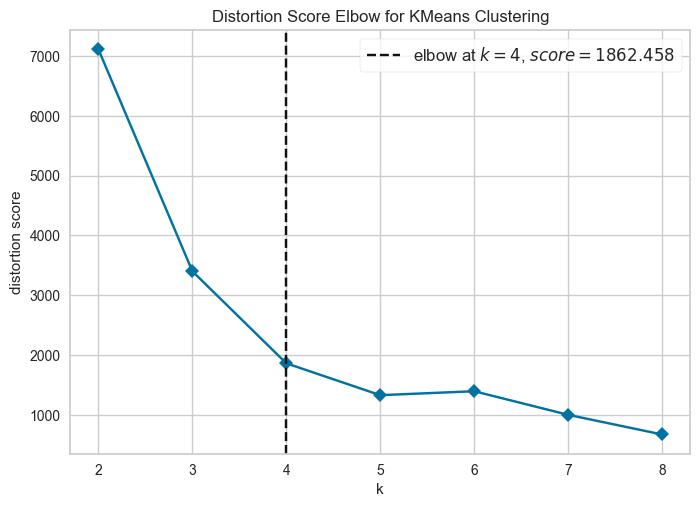

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#Calling the KMeans function
model = KMeans()

#calling the function to visualize the Elbow rule relative to the K-Means algorithm
Kelbowplot = KElbowVisualizer(model, k=(2,9), timings=False)

#Fitting the model on our data from the PCA
Kelbowplot.fit(pca_result)  

#Showing the plot
Kelbowplot.show() 

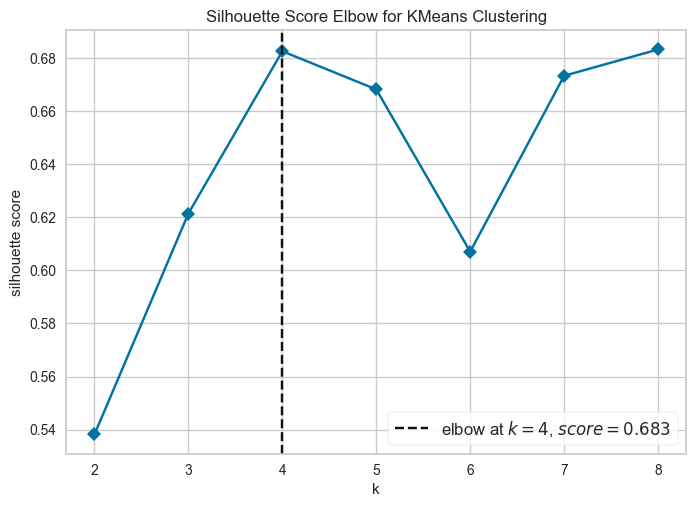

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [13]:
# Defining the visualization of the silhouette score
Silhouetteplot = KElbowVisualizer(model, k=(2,9), metric="silhouette", timings=False)

Silhouetteplot.fit(pca_result)  
Silhouetteplot.show() #showing the plot

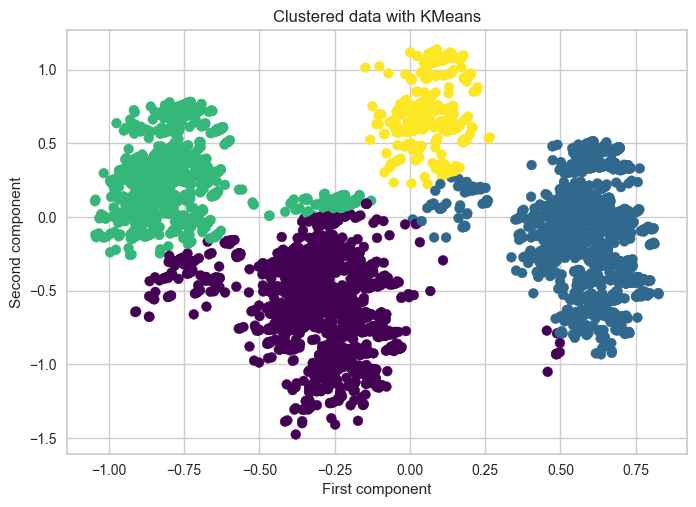

In [14]:
import matplotlib.pyplot as plt

#choose the number of clusters k for the model
kmeans = KMeans(n_clusters=4) 

#assigning every point to one of the k clusters
clustering = kmeans.fit_predict(pca_result)  

#Visulalizing our data with a scatterplot to see the clusterization
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clustering, cmap='viridis', s=50)
plt.title("Clustered data with KMeans")
plt.xlabel("First component")
plt.ylabel("Second component")
plt.show()

#### Implement the K-means clustering algorithm (not K-means++) through MapReduce. We request that you develop the algorithm from scratch based on what you've learned in class and run the algorithm on your data.

In [15]:
from pyspark import SparkContext
import numpy as np

#Function to calculate the euclidean distance
def euclidean(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Function to compute the centroids of the clusters
def computecentroids(points):
    return np.mean(points, axis=0)

#Function to map at which centroid every point is nearer
def mappingpointtocentroid(point, centroids):

    #Computing the distance of each point to every centroid
    distances = [euclidean(point, centroid) for centroid in centroids]

    #Taking only the minimum value of the distances
    closest = np.argmin(distances)

    return closest, point

# Function to compute k-means using Map Reduce algorithm
def kmeanswithmapreduce(data, k, max_iters=10):

    #Setting casually the k centroids
    centroids = data.takeSample(False, k, seed=42)
    
    # for cycle for each iteration of the algorithm
    for i in range(max_iters):

        # Applying the function to map the points and their nearer centroid 
        mapped_points = data.map(lambda point: mappingpointtocentroid(np.array(point), centroids))
        
        # Group by centroid the points, creating a list with cluster as key and the points as value, computing the new centroids after
        # having applied the mapped_points function to the points. In the end, we collect them for every iteration to search the best result
        new_centroids = mapped_points.groupByKey().mapValues(list).mapValues(computecentroids).collect()
        
        # Extracting the new centroids
        new_centroids = [x[1] for x in sorted(new_centroids)]
        
        # Break the function if the algorithm has reached its best
        if np.allclose(centroids, new_centroids):
            print(f"Convergence reached at iteration {i}")
            break
        
        #Compute the definitive centroids of our clusters
        centroids = new_centroids

    return centroids


# Calling the spark context
sparkc = SparkContext.getOrCreate()

#Applying the parallelize function, to make the operations on the clusters faster
pca_result_rddk = sparkc.parallelize(pca_result)

#defining the number of clusters
k = 4

#defining the max number of iterations of the algorithm
max_iters = 20  

#applying the algorithm of k-means with map-reduce to our data
centroidsk = kmeanswithmapreduce(pca_result_rddk, k, max_iters)

# Showing the cohordinates of the centroids
print("Final centroids:", centroidsk)


Convergence reached at iteration 9
Final centroids: [array([-0.75546701,  0.3625575 ]), array([ 0.62533126, -0.25539213]), array([0.46335027, 0.34197225]), array([-0.29631936, -0.54359489])]


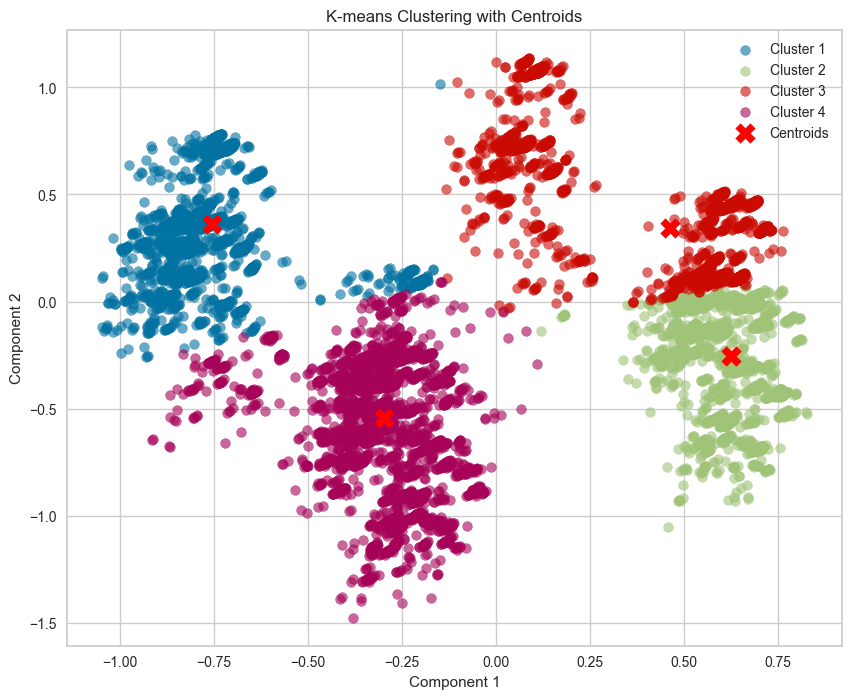

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark import SparkContext

# Function for scatterplot
def scatterplot(data_rdd, centroids):    
    # Collect data and calculate the cluster for each point
    data = data_rdd.map(lambda point: mappingpointtocentroid(np.array(point), centroids)).collect()

    # Convert the collected data to numpy arrays
    points = np.array([x[1] for x in data])  # Only the points
    labels = np.array([x[0] for x in data])  # Assigned clusters

    # Convert centroids to a numpy array
    centroids = np.array(centroids)

    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Scatter points colored by cluster
    for id in np.unique(labels):
        clusters = points[labels == id]
        plt.scatter(clusters[:, 0], clusters[:, 1], label=f'Cluster {id + 1}', s=50, alpha=0.6)

    # Scatter centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

    # Plot details
    plt.title("K-means Clustering with Centroids")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Apply the scatterplot to the RDD data and calculated centroids
scatterplot(pca_result_rddk, centroidsk)

### 2.3 Implement the K-means++ algorithm from scratch and apply it to your data. Do you notice any differences between the results obtained using random initialization and those achieved with K-means++? Please explain your observations and discuss why these differences might occur.


Convergence reached at iteration 6
Final centroids: [array([-0.29539543, -0.54408276]), array([-0.75540202,  0.36223639]), array([0.60632936, 0.03126502]), array([0.0815998, 0.8031249])]


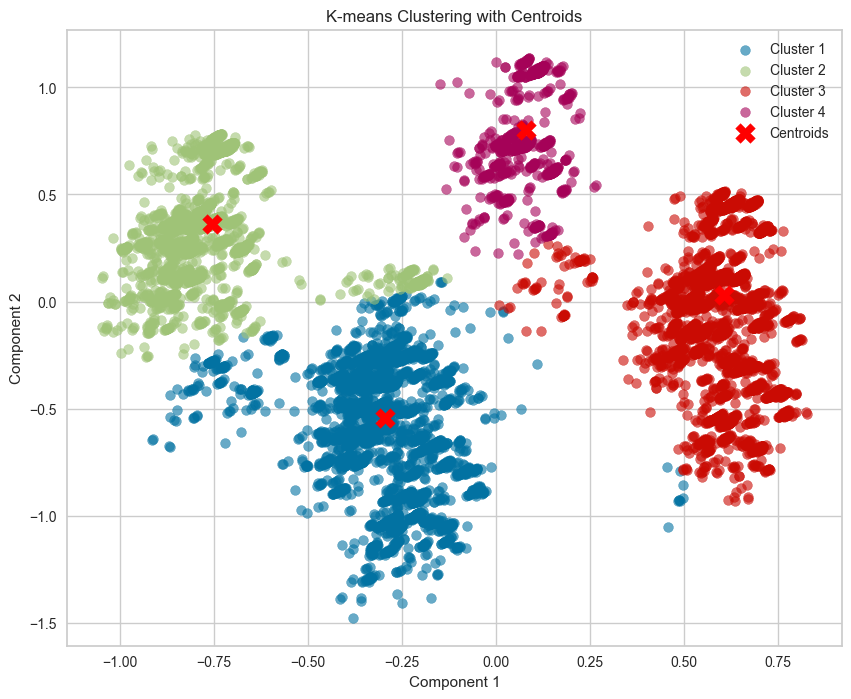

In [17]:
# Function to initialize centroids using K-means++
def kmeansplusplus_init(data, k):
    # Choose the first centroid randomly from the data points
    centroids = [data.takeSample(False, 1, seed=42)[0]]
    
    # Choose remaining centroids based on distance from the chosen centroids
    for _ in range(1, k):
        # Calculate distances to the nearest centroid for each point
        distances = data.map(lambda point: min([euclidean(point, centroid) for centroid in centroids]))
        
        # Select the next centroid with probability proportional to the distance squared
        sum_distances = distances.map(lambda x: x**2).sum()
        rand_val = np.random.rand() * sum_distances
        
        cumulative_sum = 0
        for idx, dist in enumerate(distances.collect()):
            cumulative_sum += dist**2
            if cumulative_sum >= rand_val:
                centroids.append(data.collect()[idx])
                break
    
    return centroids

# Function to compute k-means with MapReduce and K-means++ initialization
def kmeanspluspluswithmapreduce(data, k, max_iters=10):
    # Initialize centroids using K-means++
    centroids = kmeansplusplus_init(data, k)
    
    # Iterate for the given number of iterations
    for i in range(max_iters):
        # Apply the function to map the points and their nearest centroid
        mapped_points = data.map(lambda point: mappingpointtocentroid(np.array(point), centroids))
        
        # Group by centroid and compute new centroids
        new_centroids = mapped_points.groupByKey().mapValues(list).mapValues(computecentroids).collect()
        
        # Extract the new centroids
        new_centroids = [x[1] for x in sorted(new_centroids)]
        
        # Break the loop if the algorithm has converged (centroids don't change)
        if np.allclose(centroids, new_centroids):
            print(f"Convergence reached at iteration {i}")
            break
        
        # Update centroids
        centroids = new_centroids
    
    return centroids

# Calling the spark context
sparkc = SparkContext.getOrCreate()

# Applying the parallelize function to make the operations on the clusters faster
pca_result_rdd = sparkc.parallelize(pca_result)

# Defining the number of clusters
k = 4

# Defining the max number of iterations of the algorithm
max_iters = 20 

# Applying the K-means algorithm with K-means++ initialization
centroids = kmeanspluspluswithmapreduce(pca_result_rdd, k, max_iters)

# Showing the coordinates of the final centroids
print("Final centroids:", centroids)
scatterplot(pca_result_rdd, centroids)

#### 2.2.4 Ask an LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to recommend another clustering algorithm. Use that LLM to describe the workings of the algorithm, as well as its advantages and disadvantages compared to K-means and K-means++. Additionally, ask to implement the algorithm for you or utilize an existing version from a package. Apply that algorithm to your data and explain any differences you observe in the results compared to those obtained previously.

Recommended Clustering Algorithm: DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
LLM (ChatGPT) Recommendation:

I would recommend DBSCAN (Density-Based Spatial Clustering of Applications with Noise) as an alternative clustering algorithm to K-means and K-means++. DBSCAN is a density-based clustering algorithm that works by grouping together points that are closely packed based on a distance metric (usually Euclidean distance). Unlike K-means, which requires the user to specify the number of clusters, DBSCAN requires two parameters:

ε (epsilon): The maximum distance between two points for them to be considered as part of the same neighborhood.
MinPts: The minimum number of points required to form a dense region (a cluster).
DBSCAN does not require the number of clusters to be specified beforehand. It can identify clusters of arbitrary shape and also has the ability to identify outliers (points that do not belong to any cluster).

How DBSCAN Works:
Core Points: Points that have at least MinPts points within a distance of ε (including themselves).
Border Points: Points that are within the ε distance of a core point, but do not have enough neighbors to be core points themselves.
Noise: Points that do not belong to any cluster (neither core nor border points).
The algorithm proceeds as follows:

It starts with an arbitrary point and checks if it is a core point. If it is, a cluster is formed, and the algorithm expands to include all points within the ε neighborhood of this point.
If the point is not a core point, it is classified as noise or assigned to a cluster if it is within a border region of an existing cluster.
Advantages of DBSCAN:
No need to specify the number of clusters: Unlike K-means, DBSCAN does not require specifying the number of clusters beforehand.
Ability to find clusters of arbitrary shape: K-means assumes clusters are spherical or circular in shape, while DBSCAN can detect clusters of irregular shape.
Robust to outliers: Points that do not fit into any cluster (outliers) are automatically identified as noise.
Disadvantages of DBSCAN:
Sensitive to the choice of parameters: The algorithm is sensitive to the values of ε and MinPts. A poor choice of parameters can lead to incorrect clustering.
Not well suited for high-dimensional data: The concept of distance becomes less meaningful in high-dimensional spaces (curse of dimensionality), which can make DBSCAN less effective in such cases.
Performance issues: DBSCAN may be slower than K-means on large datasets due to the complexity of calculating neighborhoods.
Comparing DBSCAN with K-means/K-means++:
K-means is a centroid-based algorithm, making it more sensitive to outliers and requiring the user to specify the number of clusters. DBSCAN, being density-based, handles outliers better and does not require the number of clusters to be predefined.
K-means++ improves K-means by initializing centroids in a more robust manner, but it still assumes spherical clusters and is sensitive to the number of clusters. DBSCAN, on the other hand, can detect clusters of arbitrary shapes and automatically handles noise.
Implementing DBSCAN with Python
Now, let’s implement DBSCAN using the popular scikit-learn package and apply it to the same dataset (pca_result).

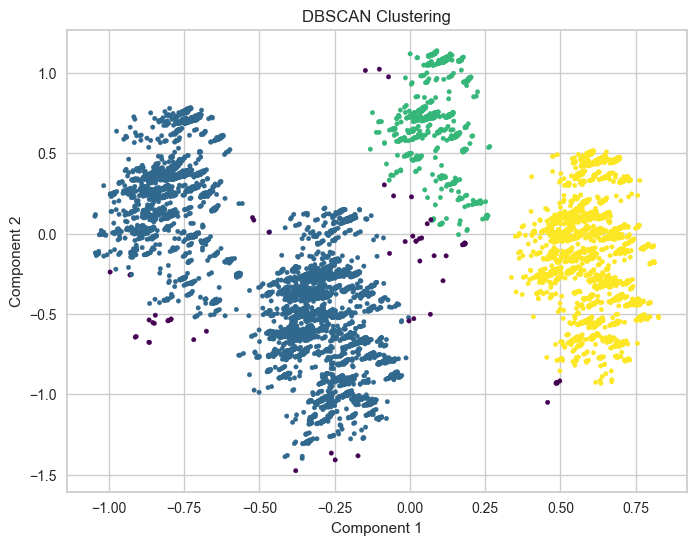

Number of clusters found: 3


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

#Computing the DBSCAN, with epsilon that equals the maximum distance within two points needs to stay to be considered as a part of the same cluster and
# min_samples, instead, which is the minimum size a cluster can have.
dbscan = DBSCAN(eps=0.095, min_samples=20)
labels_dbscan = dbscan.fit_predict(pca_result)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_dbscan, cmap="viridis", s=10)
plt.title("DBSCAN Clustering")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Show number of clusters found (excluding noise points)
num_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"Number of clusters found: {num_clusters}")


The DBSCAN algorithm with eps = 0.1 and minimum size of cluster = 20 has found 3 clusters.

### 2.4 Best Algorithm

Clustering helps identify natural groupings within data, but no single algorithm works best for every dataset. In this section, you’ll learn how to choose the most suitable clustering method based on your data’s unique characteristics. By analyzing patterns and comparing results, you’ll uncover which algorithm provides the most meaningful insights and clusters.

- Set the number of clusters to the optimal number k_opt based on any of the methods previously.
- Select three distinct metrics to assess the quality of the clusters. Describe each metric in detail, including the specific aspects they evaluate to determine the effectiveness of the clustering model.
- Apply the three clustering algorithms used in the prior section to partition the data into k_opt clusters. Then, evaluate each model's clustering quality using the selected metrics. Summarize your findings by comparing the results of each algorithm based on the metric evaluations.

#### Set the number of clusters to the optimal number k_opt based on any of the methods previously.
We will determine k_opt using the Elbow Method or Silhouette Analysis, which were likely introduced earlier. Assuming k_opt = 3 (as an example from prior results), we will proceed with this value. If needed, the optimal k_opt can be re-determined.

In [19]:
# Optimal number of clusters, set to 4 by results of K-means and K-means++
k_opt = 4

#### Select three distinct metrics to assess the quality of the clusters. Describe each metric in detail, including the specific aspects they evaluate to determine the effectiveness of the clustering model.
- Silhouette Score: this metric computes, for each data point, a score that compares the average distance to points in its own cluster (cohesion) with the average distance to the nearest neighboring cluster (separation). The score reflects how well the point fits within its assigned cluster versus other clusters. High scores indicate that clusters are compact (low intra-cluster distance) and well-separated (high inter-cluster distance). Points with scores near -1 suggest poor cluster assignment. 
Range: [-1, 1]  

- Davies-Bouldin Index or DBI: This metric computes the ratio between intra-cluster dispersion (compactness, e.g., measured by standard deviation) and inter-cluster separation (distance between cluster centers). For each pair of clusters, it determines a similarity score, and the DBI is the average of these scores. Low values indicate that clusters are compact and distinct from each other. High DBI scores suggest overlapping clusters or poor separation. Values of DBI are always equal or greater than 0.

- Calinski-Harabasz Index: this metric is based on the ratio of the variance explained between clusters, so how distinct the clusters are, to the variance within clusters (how compact they are). Higher scores indicate better separation and cohesion. The metric rewards cluster configurations where clusters are far apart from each other and internally dense. It also accounts for the number of clusters, penalizing configurations with too few or too many clusters relative to the data distribution. Also for CH, values cannot be smaller than 0 and don't have any upper bound.

#### Apply the three clustering algorithms used in the prior section to partition the data into k_opt clusters. Then, evaluate each model's clustering quality using the selected metrics. Summarize your findings by comparing the results of each algorithm based on the metric evaluations.

Convergence reached at iteration 9
Convergence reached at iteration 5
             Algorithm  Silhouette Score  Davies-Bouldin Index  \
0  K-means (MapReduce)          0.522968              0.678252   
1            K-means++          0.682604              0.404376   
2               DBSCAN          0.528852              0.637781   

   Calinski-Harabasz Index  
0             42429.318136  
1             62421.688561  
2             23624.234671  


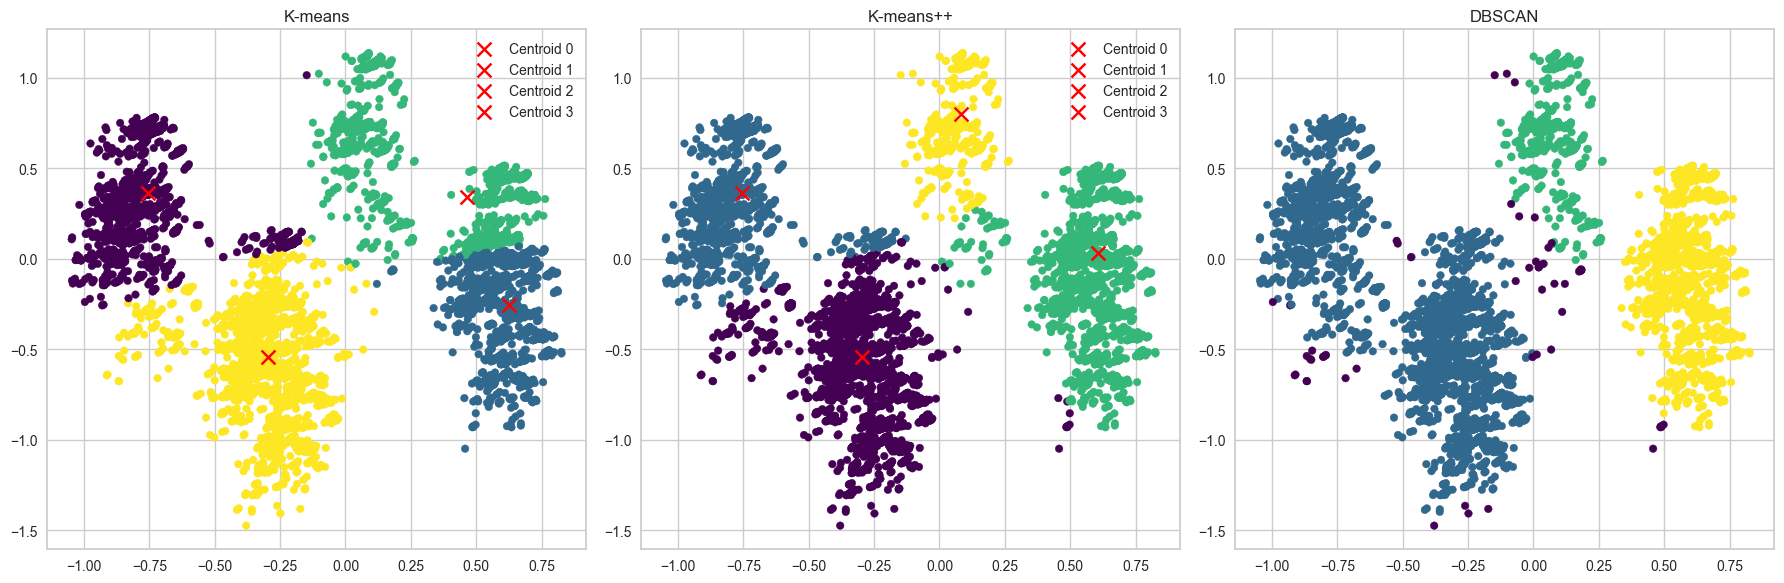

In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calling the spark context
sparkc = SparkContext.getOrCreate()

# Applying the parallelize function to make the operations on the clusters faster
pca_result_rdd = sparkc.parallelize(pca_result)

#Defining two different dataframes for the two k-means algorithms
pca_result_rddk = pca_result_rdd

# Setting the maximum number of iterations
max_iters = 10

#Computing the K-means with Map Reduce for the data we provided
centroidsk = kmeanswithmapreduce(pca_result_rddk, k_opt, max_iters)

#Defining the labels for the K-means algorithm
labels_kmeans_mapreduce = (
    pca_result_rddk.map(lambda point: mappingpointtocentroid(np.array(point), centroidsk))
    .map(lambda x: x[0])
    .collect()
)

#Computing the K-means++ with Map Reduce for the data we provided
centroidsplus = kmeanspluspluswithmapreduce(pca_result_rdd, k, max_iters)

#Defining the labels for the K-means++ algorithm
labels_kmeansplus_mapreduce = (
    pca_result_rdd.map(lambda point: mappingpointtocentroid(np.array(point), centroids))
    .map(lambda x: x[0])
    .collect()
)

#Applying the DBSCAN clustering with epsilon = 0.088 and minimum size of a cluster = 20
#dbscan = DBSCAN(eps=0.1, min_samples=20)

#Defining the labels for the dbscan algorithm
#labels_dbscan = dbscan.fit_predict(pca_result)

# Creating an empty matrix that will be filled with all metrics for the three algorithms
metrics = {
    "Algorithm": [],
    "Silhouette Score": [],
    "Davies-Bouldin Index": [],
    "Calinski-Harabasz Index": [],
}

# Defining the function to calculate the three different metrics for each algorithm
def compute_metrics(algorithm_name, data, labels):

    #In first row we put the name of the algorithm
    metrics["Algorithm"].append(algorithm_name)

    #Computing the Silhouette score, Davies-Bouldin index and Calinski-Harabasz index relative to the chosen algorithm
    metrics["Silhouette Score"].append(silhouette_score(data, labels)) 
    metrics["Davies-Bouldin Index"].append(davies_bouldin_score(data, labels))
    metrics["Calinski-Harabasz Index"].append(calinski_harabasz_score(data, labels))


# Compute metrics for K-means
compute_metrics("K-means (MapReduce)", pca_result, labels_kmeans_mapreduce)

# Compute metrics for K-means++
compute_metrics("K-means++", pca_result, labels_kmeansplus_mapreduce)

# Compute metrics for DBSCAN (excluding noise points)
filtered_data_dbscan = pca_result[labels_dbscan != -1]
filtered_labels_dbscan = labels_dbscan[labels_dbscan != -1]

#applying the function "compute metrics" on the data with dbscan algorithm applied
compute_metrics("DBSCAN", filtered_data_dbscan, filtered_labels_dbscan)

# Showing results relative to the metrics
results = pd.DataFrame(metrics)
print(results)

# Creating the visualization for the three different clustering algorithms
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Visualizing the K-Means clusters(left plot)
ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=labels_kmeans_mapreduce, cmap="viridis", s=30)
for idx, centroid in enumerate(centroidsk):
    ax[0].scatter(centroid[0], centroid[1], c="red", marker="x", s=100, label=f"Centroid {idx}")
ax[0].set_title("K-means")
ax[0].legend()

# Visualizing the K-Means++ clusters(middle plot)
ax[1].scatter(pca_result[:, 0], pca_result[:, 1], c=labels_kmeansplus_mapreduce, cmap="viridis", s=30)
for idx, centroid in enumerate(centroids):
    ax[1].scatter(centroid[0], centroid[1], c="red", marker="x", s=100, label=f"Centroid {idx}")
ax[1].set_title("K-means++")
ax[1].legend()

# Visualizing the DBSCAN clusters(right plot)
ax[2].scatter(pca_result[:, 0], pca_result[:, 1], c=labels_dbscan, cmap="viridis", s=30)
ax[2].set_title("DBSCAN")

plt.tight_layout()
plt.show()


The K-Means++ results the best algorithm among the three of them. First thing to say is that the DBscan algorithm doesn't have the chance to be fitted with a predefined number of clusters. Therefore, when there is a need to use a fixed k, as in this case, the DBSCAN parameters are heavily adjusted to make it comply with the desired number of clusters. However, this manipulation makes the results less effective, as DBSCAN is not designed to return a specific number of clusters.  
It is no surprise, then, that DBSCAN produces the worst results across all indices except for the DBI, where K-Means performs worse. On the other hand, K-Means++ proves to be the best according to all three metrics considered. Even when observing the graph, it is visually clear that K-Means++ better matches the division into 4 groups that one would expect when looking at the scatterplot and imagining a possible clustering.

## 3. Bonus Question
K-means is an iterative algorithm, meaning that with each iteration, it refines the clusters by adjusting them based on the distance of each data point relative to the center of each cluster. This process continues until it reaches a point of convergence or hits a set limit on the number of iterations. You might want to track the progress of forming your clusters.

Select two variables* from your instances to display them on a 2D plot. Then, illustrate the progression of the clusters as they change at each iteration. We expect a plot for each iteration, displaying the instances and the clusters they belong to. Select the two features that most effectively separate visual instances belonging to different clusters. Explain the method you used to determine these features.
*Note: Depending on the variables you want to use for clustering, whether they are the original movie features or the components derived from PCA, you may select two features/components that best help to visually display the clusters.

Convergence reached at iteration number 8


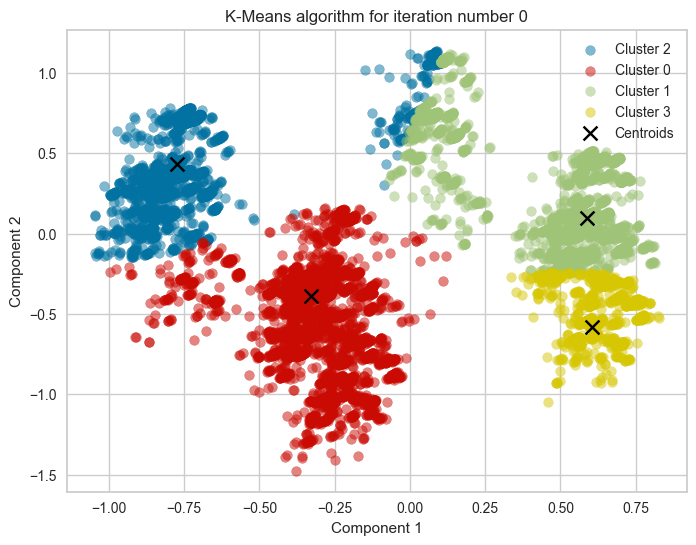

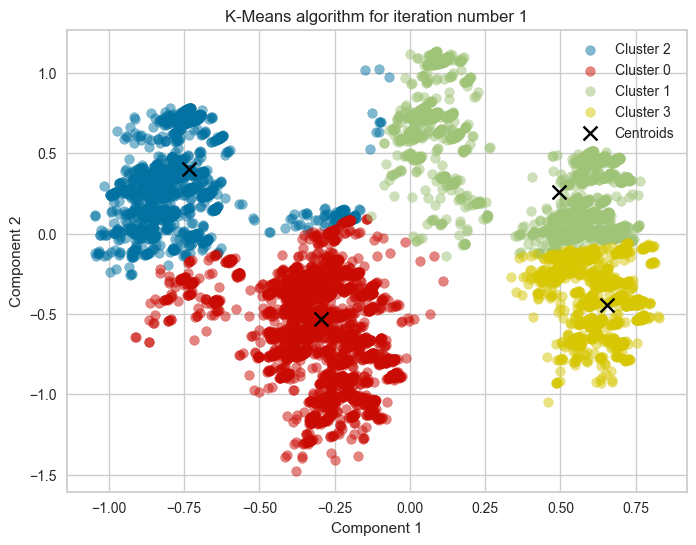

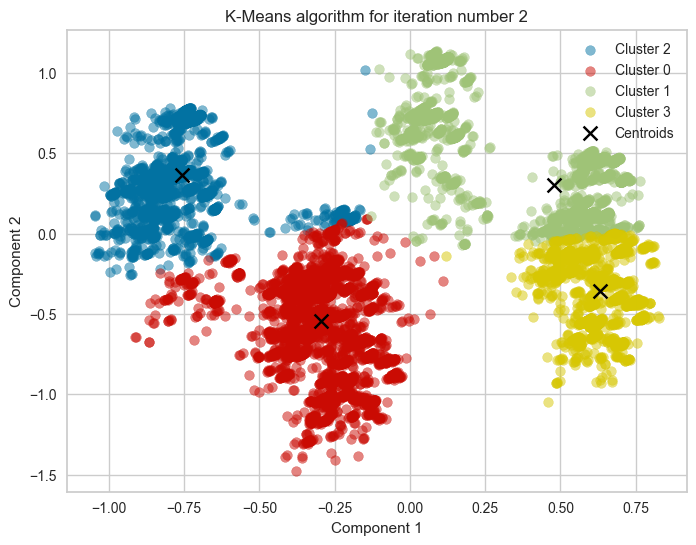

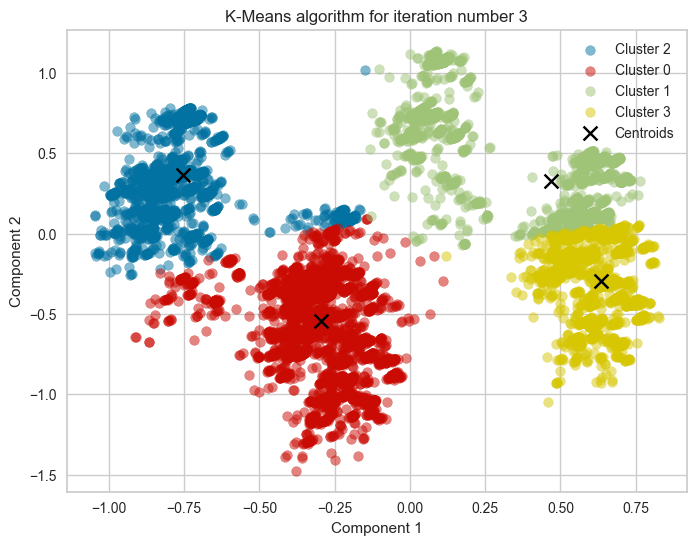

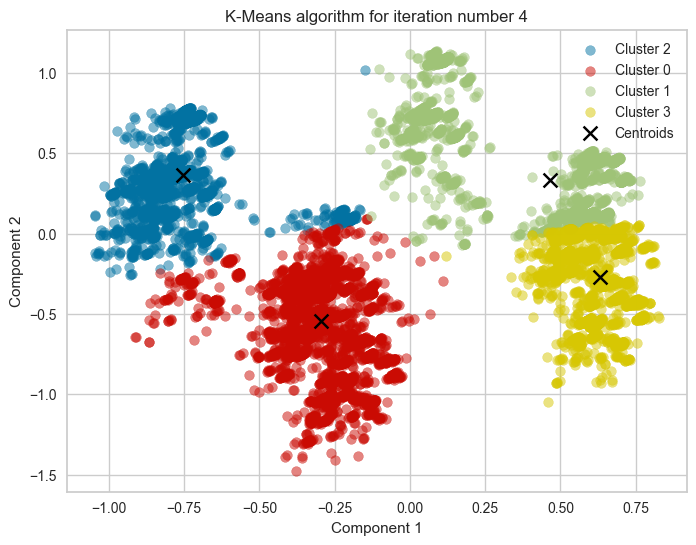

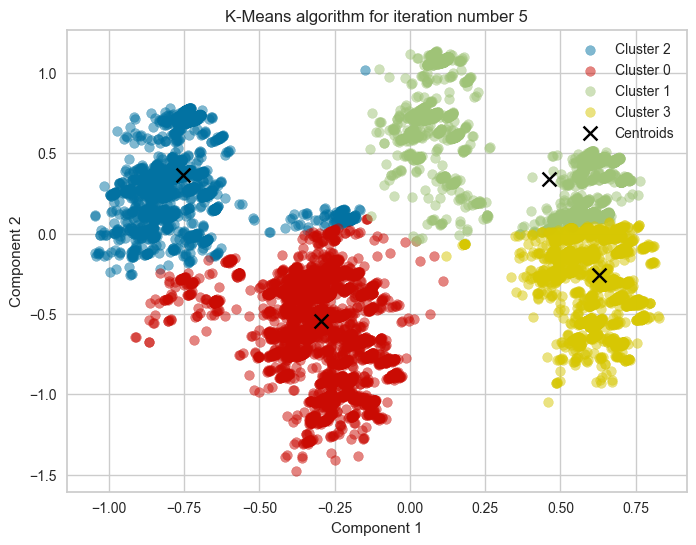

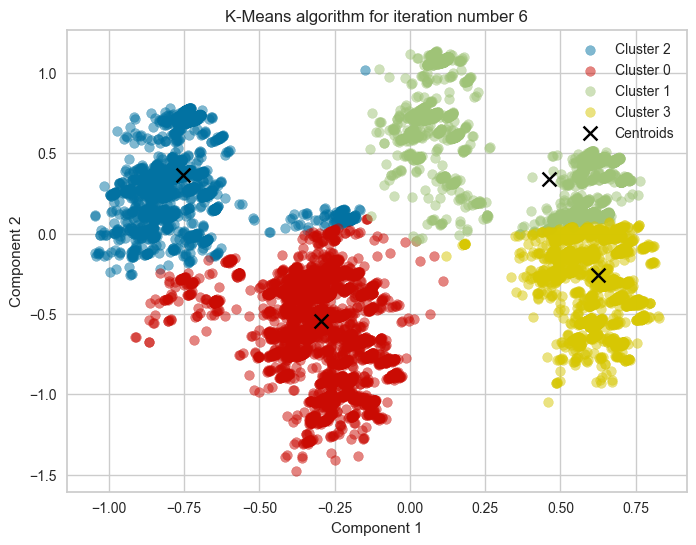

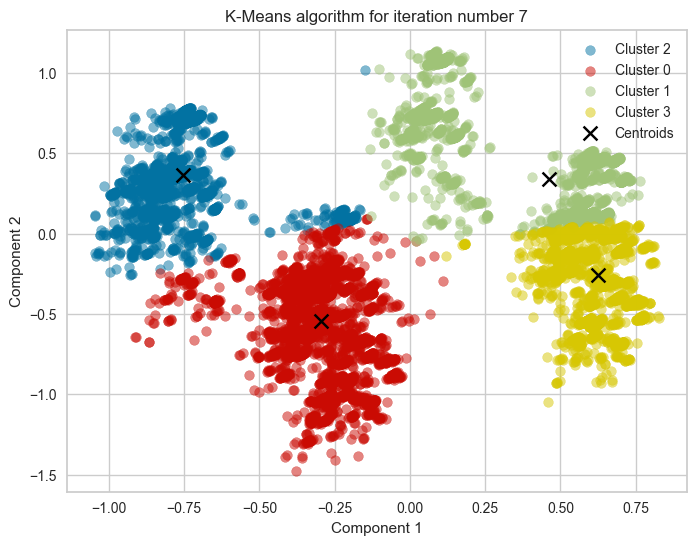

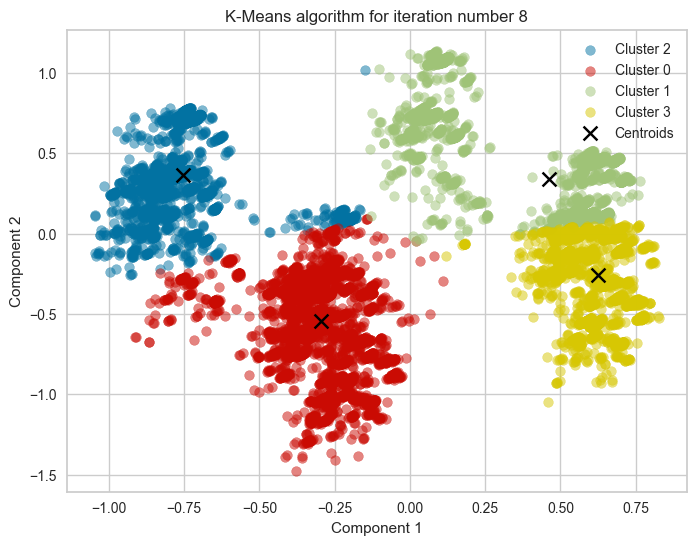

In [21]:
from pyspark import SparkContext
import numpy as np
import matplotlib.pyplot as plt

#initialize spark context
sparkc = SparkContext.getOrCreate()

# define the visualization function
def track_progress(data, progress, ind=(0, 1)):
    #data_points = np.array(data.collect())

    #looping through each iteration's centroids and cluster assignments saved in list "progress", defined later
    for i, (iteration, centroids, cluster_assignments) in enumerate(progress):
        plt.figure(figsize=(8, 6))
        colors = ['r', 'g', 'b', 'y']

        #Creating a dictionary to save every point to its cluster
        assignments = {}

        #creating a cycle for each cluster and point
        for id, point in cluster_assignments:

            #Creating the key if the cluster id hasn't been saved before
            if id not in assignments:
                assignments[id] = []
            
            #for each point, append it at its relative cluster
            assignments[id].append(point)
        
        # creating a loop to plot the points, assigned to their clusters
        for id, points in assignments.items():
            points = np.array(points)
            plt.scatter(points[:, ind[0]], points[:, ind[1]], color=colors[id], label=f"Cluster {id}", alpha=0.5)
        
        #plotting the centroids of the clusters
        centroids = np.array(centroids)
        plt.scatter(centroids[:, ind[0]], centroids[:, ind[1]], color='black', marker='x', s=100, label='Centroids')
        plt.title(f"K-Means algorithm for iteration number {iteration}")
        plt.xlabel(f"Component 1")
        plt.ylabel(f"Component 2")
        plt.legend()
        plt.show()

# Function to initialize the k-means++ and the progress list to keep track of the iterations
def tracking(data, k, max_iters=10):
    centroids = kmeansplusplus_init(data, k)
    progress = []

    # iterating till the max value setted
    for i in range(max_iters):

        #assigning the points to the clusters
        mapped_points = data.map(lambda point: mappingpointtocentroid(np.array(point), centroids))

        #grouping points by cluster, then assigning the new position of the clusters 
        groups = mapped_points.groupByKey().mapValues(list)
        new_centroids = groups.mapValues(computecentroids).collect()

        #sorting the new centroids by id
        new_centroids = [x[1] for x in sorted(new_centroids)]

        #collecting the points assigned to any cluster with the function "mapped_points"
        points_assigned = mapped_points.collect()

        #appending the new ids, centroids and points assigned to the "progress" list        
        progress.append((i, centroids.copy(), points_assigned))

        #interrupting the process if the centroids doesn't change
        if np.allclose(centroids, new_centroids):
            print(f"Convergence reached at iteration number {i}")
            break

        #updating the cohordinates of the centroids
        centroids = new_centroids
    return centroids, progress

# executes the K-Means++ algorithm and tracks its progress
centroids, progress = tracking(pca_result_rdd, k, max_iters)

# Visualize the progresses
track_progress(pca_result_rdd, progress, ind=(0, 1))


In [22]:
# final cell to stop the spark session
# Stopping the Spark context
sparkc.stop()
spark.stop()

## 4. Algorithmic Question
Two brilliant strategists, Arya and Mario, are about to play a game with a sequence of numbers. Arya, as player 1, begins the game, while Mario, player 2, plays 2nd. Their goal is clear: to collect the highest possible score by taking numbers from either end of the sequence, one at a time. They will play in perfect synchronicity, each seeking the advantage.

The sequence represented as an array of nums, is laid out in front of them. Arya will start by selecting either the number at the beginning (nums[0]) or the end (nums[nums.length - 1]) of the array, adding that value to her score. This value is then removed from the beginning or the end of nums. Then, it’s Mario’s turn to do the same with the remaining sequence. The game proceeds this way, with each player taking numbers from either end until no numbers are left to claim. The player with the highest score wins.

However, if they end in a tie, Arya, as the first to act, will claim victory by default.

Arya is now before you, asking for help to predict her chances. She wants to know, with her best possible choices, whether she can guarantee a win, assuming both players play with perfect skill.
- a) Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally)

To guarantee victory, Arya must not only maximize her score but also minimize Mario's opportunities to secure higher-value scores. Choosing an immediate, tempting gain might cost her a more valuable score later. Thus, she must anticipate the possible scenarios she may face. In other words, to determine whether Arya’s victory is guaranteed, we need to compare the maximum score she can achieve with Mario’s maximum score, assuming both play optimally.
Specifically, the maximum score Arya can achieve by taking a number from either the beginning or the end of the array is calculated as the maximum between the score obtained by:
Choosing the number at the beginning plus the total sum of the array minus the optimal score Mario can achieve from the remaining numbers, and
Choosing the number at the end plus the total sum of the array minus the optimal score Mario can achieve from the remaining numbers.
The optimal gain for any subarray nums[i:j] can be expressed as:

optimal_gain = max(nums[i] + sum(nums[i:j]) - optimal_score_in_remaining_numbers,nums[j] + sum(nums[i:j]) - optimal_score_in_remaining_numbers)

After defining how to compute the optimal_gain, we can simulate all possible situations during the game based on the choices of taking numbers from either the beginning or the end of the array.  The maximum value of the optimal_gain among all subarrays represents the highest score Arya can achieve by playing optimally.


<Strong>Function</Strong> max_score_1(nums, i, j):<br>
    <Strong>Input:</Strong> nums: list of numbers, i, j: initial and ending indexes of the subarray<br>
    <Strong>Output:</Strong> Maximum score Arya can achieve in the subarray<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>if</Strong> i is equal to j <Strong>then</Strong>:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> nums[i]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>end if</Strong><br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;array_sum &larr; sum of nums[i:j+1]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;take_start &larr; nums[i] + (array_sum - max_score_1(nums, i+1, j))<br>
    &nbsp;&nbsp;&nbsp;&nbsp;take_end &larr; nums[j] + (array_sum - max_score_1(nums, i, j-1))<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;result &larr; max(take_start, take_end)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> result<br><br>
    <Strong>end</Strong><br><br>

<Strong>Function</Strong> predict_victory_1(nums):<br>
    <Strong>Input:</Strong> nums: list of integers<br>
    <Strong>Output:</Strong> Boolean indicating whether Arya can guarantee a win or not<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;n &larr; length of nums<br>
    &nbsp;&nbsp;&nbsp;&nbsp;arya_score &larr; max_score_1(nums, 0, n-1)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;total_score &larr; sum of nums<br>
    &nbsp;&nbsp;&nbsp;&nbsp;mario_score &larr; total_score - arya_score<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> arya_score is greater than or equal to mario_score<br><br>
    <Strong>end</Strong><br><br>

<Strong>Algorithm</Strong> main():<br>
    <Strong>Output:</Strong> Prints whether Arya can guarantee a win or not<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;nums &larr; [sequence of numbers]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;result &larr; predict_victory_1(nums)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Print result<br>
    <Strong>end</Strong>



- b) Write a Python program implementing her game strategy. Try different array lengths to test the algorithm.

In [ ]:
import random
def max_score_1(nums, i, j):
    #If the subarray has only one number
    if i == j:
        return nums[i]
    #Sum of the subarray nums[i:j+1]
    array_sum = sum(nums[i:j+1])
    #Arya has two choices
    take_start = nums[i] +(array_sum-max_score_1(nums,i+1,j))
    take_end = nums[j] +(array_sum-max_score_1(nums,i,j-1))
    #Maximum score between two choices
    result = max(take_start, take_end)
    return result

def predict_victory_1(nums):
    n =len(nums)
    arya_score =max_score_1(nums, 0,n-1)
    total_score =sum(nums)
    mario_score =total_score-arya_score
    return arya_score >mario_score or(arya_score == mario_score)

array = [[31, 5, 233, 7,423,234,1,321,2,1,3,3,1,31,1],
         [1, 5, 2,3,42,41,1,11,1],
         [11, 5, 233, 27,423,234,1,321,2,77,543,423,52,55,53,1,1,31],
         [1, 5, 233, 7,43,234,1,321,2,1,3,3,1,43,21312,5,312,1,10],
         [random.randint(1, 50) for _ in range(15)],
         [random.randint(1, 50) for _ in range(20)],
         [random.randint(1, 50) for _ in range(25)]]
for item in array:
    arya_result= predict_victory_1(item)
    print(arya_result)


- c) Is the algorithm efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time.

The most computationally expensive operation in the `predict_victory_1` algorithm lies in the `max_score_1` function. This function is recursive and makes two calls for each invocation, corresponding to the two possible choices Arya can make: selecting the number at the beginning or the end of the array. <br>
Each recursive call reduces the problem size by 1 (i.e., from size `n` to `n-1`), and it leads to a time complexity of approximately  $O(2^n) $.<br>
Additionally, the algorithm includes some `sum` operations which, in the most computationally expensive case, have a time complexity of $O(n)$. However, these operations are less dominant compared to the recursive function `max_score_1`. All other operations within the algorithm have constant complexity and therefore do not affect the overall asymptotic complexity.<br>
In conclusion, the algorithm has an overall time complexity of $O(2^n) $, which is exponential. Such complexity makes the algorithm inefficient for large inputs.


- d) If the algorithm is exponential, explain how to make it polynomial and provide a pseudocode for it. Recompute the computational complexity of the updated algorithm.

Each time the algorithm computes the optimal gain of a subarray, all necessary calculations are performed. However, there may be a significant amount of repetitive computation. For instance, in the array [1, 3, 5, 2, 3, 1], the subarray [5, 2] may need to be computed multiple times based on how the two players choose their numbers. This characteristic significantly slows down the performance of the algorithm.
Fortunately, this inefficiency can be addressed using dynamic programming. By storing the result of each computation in a memoization dictionary, subsequent requests for the same computation can be retrieved in 
$O(1)$ time. This approach drastically accelerates the execution of the algorithm. The pseudocode for the updated algorithm is as follows:<br><br>
<Strong>Function</Strong> max_score_2(nums, i, j, memo):<br>
    <Strong>Input:</Strong> nums: list of numbers, i, j: initial and ending indexes of the subarray, memo: dictionary for memoization<br>
    <Strong>Output:</Strong> Maximum score Arya can achieve in the subarray<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>if</Strong> i is equal to j <Strong>then</Strong>:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> nums[i]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>end if</Strong><br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>if</Strong> (i, j) exists in memo <Strong>then</Strong>:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> memo[(i, j)]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>end if</Strong><br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;array_sum &larr; sum of nums[i:j+1]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;take_start &larr; nums[i] + (array_sum - max_score_2(nums, i+1, j, memo))<br>
    &nbsp;&nbsp;&nbsp;&nbsp;take_end &larr; nums[j] + (array_sum - max_score_2(nums, i, j-1, memo))<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;result &larr; max(take_start, take_end)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;memo[(i, j)] &larr; result<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> result<br><br>
    <Strong>end</Strong><br><br>

<Strong>Function</Strong> predict_victory_2(nums):<br>
    <Strong>Input:</Strong> nums: list of integers<br>
    <Strong>Output:</Strong> Boolean indicating whether Arya can guarantee a win or not<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;n &larr; length of nums<br>
    &nbsp;&nbsp;&nbsp;&nbsp;memo &larr; {}<br>
    &nbsp;&nbsp;&nbsp;&nbsp;arya_score &larr; max_score_2(nums, 0, n-1, memo)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;total_score &larr; sum of nums<br>
    &nbsp;&nbsp;&nbsp;&nbsp;mario_score &larr; total_score - arya_score<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> arya_score is greater than or equal to mario_score<br><br>
    <Strong>end</Strong><br><br>

<Strong>Algorithm</Strong> main():<br>
    <Strong>Output:</Strong> Prints whether Arya can guarantee a win or not<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;nums &larr; [sequence of numbers]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;result &larr; predict_victory_2(nums)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Print result<br>
    <Strong>end</Strong>


The updated algorithm provides a polynomial time complexity, as it avoids computing repetitive subarrays multiple times. Instead, each subarray is computed exactly once by using a memoization dictionary. The total number of unique subarrays is $\frac{n(n+1)}{2}$​, which can be generalized to $O(n^2)$, making the algorithm polynomial in time complexity.

- e) Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times.

In [2]:
import random
def max_score_2(nums, i, j, memo):
    #If the subarray has only one number
    if i == j:
        return nums[i]
    #If the subarray is already computed, return its value
    if (i, j) in memo:
        return memo[(i, j)]
    #Sum of the subarray nums[i:j+1]
    array_sum = sum(nums[i:j+1])
    #Arya has two choices
    take_start = nums[i] +(array_sum-max_score_2(nums,i+1, j,memo))
    take_end = nums[j] +(array_sum-max_score_2(nums, i,j-1,memo))
    #Maximum score between two choices
    result = max(take_start, take_end)
    #Save the result in memoization dictionary
    memo[(i, j)] = result
    return result

def predict_victory_2(nums):
    n = len(nums)
    memo = {}
    arya_score =max_score_2(nums, 0,n-1,memo)
    total_score =sum(nums)
    mario_score =total_score-arya_score
    return arya_score > mario_score or (arya_score == mario_score)

array = [[31, 5, 233, 7,423,234,1,321,2,1,3,3,1,31,1],
         [1, 5, 2,3,42,41,1,11,1],
         [11, 5, 233, 27,423,234,1,321,2,77,543,423,52,55,53,1,1,31],
         [1, 5, 233, 7,43,234,1,321,2,1,3,3,1,43,21312,5,312,1,10],
         [random.randint(1, 50) for _ in range(15)],
         [random.randint(1, 50) for _ in range(20)],
         [random.randint(1, 50) for _ in range(25)]]
for item in array:
    arya_result= predict_victory_2(item)
    print(arya_result)


False
False
True
False
True
True
True


Comparing the result values and running times

In [ ]:
import time

array = [[1, 5, 233, 7],
         [1, 5, 2,3,42,41,1,11,1],
         [11, 5, 233, 27,423,234,1,321,2,77,543,423,52,55,53,1,1,31],
         [1, 5, 233, 7,43,234,1,321,2,1,3,3,1,43,21312,5,312,1,10],
         [1, 15, 2323, 7,43,234,1,521,2,1,3,3,3,43,212,5,12],
         [1,12,12,123,1,4,5432,5645,6,523,423,423,251,4,124,12,4,12,5,47,65,98,76,8,5,3235,2]]

start_time_ndp = time.time()
print("Start running the algorithm without dynamic programming")
for item in array:

    arya_result= predict_victory_1(item)
    print(arya_result)

end_time_ndp = time.time()
print("End")
execution_time_ndp = end_time_ndp -start_time_ndp

start_time_dp = time.time()
print("Start running the algorithm with dynamic programming")
for item in array:

    arya_result= predict_victory_2(item)
    print(arya_result)

end_time_dp = time.time()
print("End")
execution_time_dp = end_time_dp -start_time_dp

print(f"Running time for the algorithm without dynamic programming: {execution_time_ndp} seconds")
print(f"Running time for the algorithm with dynamic programming: {execution_time_dp} seconds")



As demonstrated by the previous test, both algorithms are able to correctly predict the result of the game, assuming both players play optimally. However, there is one aspect in which the two algorithms differ significantly: their running time. Specifically, the algorithm with dynamic programming is significantly faster than the one without dynamic programming, due to its ability to compute each subarray only once.

- f) Finally, consult LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to craft a third, optimized implementation and analyze its time complexity. Also, explain if the LLM is doing a good job and how you can evaluate whether the suggested solution works properly.

We posed the following question to ChatGPT:<br><br>
Hello ChatGPT, I have an algorithm called predict_victory_1, which does not use dynamic programming.

#### Pseudocode of the algorithm predict_victory_1 ####

I also have a second algorithm, predict_victory_2, which uses dynamic programming and runs significantly faster.

#### Pseudocode of the algorithm predict_victory_2 ####

Can you craft a third, optimized implementation and analyze its time complexity?<br><br>
here is its answer<br><br><br>
# Optimized Implementation: `predict_victory_3`

### Algorithm Explanation
1. Use a 2D table `dp` such that `dp[i][j]` represents the maximum score Arya can achieve for the subarray `nums[i:j+1]`.
2. **Base Case**: When `i == j`, `dp[i][i] = nums[i]` (Arya can only take one element).
3. **Transition**: To calculate `dp[i][j]` for `i < j`:
   - If Arya takes the first element `nums[i]`, her score is `nums[i] + (sum(nums[i:j+1]) - dp[i+1][j])`.
   - If Arya takes the last element `nums[j]`, her score is `nums[j] + (sum(nums[i:j+1]) - dp[i][j-1])`.
   - `dp[i][j] = max(take_start, take_end)`.
4. To save on repeatedly calculating the sum of `nums[i:j+1]`, maintain a **prefix sum** array.
5. Compute `dp[i][j]` iteratively for increasing lengths of subarrays.
6. Finally, compare Arya's maximum score (`dp[0][n-1]`) with Mario's score to determine the winner.

---

### Code Implementation

```python
def predict_victory_3(nums):
    n = len(nums)
    # Prefix sum array for fast range sum computation
    prefix_sum = [0] * (n + 1)
    for i in range(n):
        prefix_sum[i + 1] = prefix_sum[i] + nums[i]
    
    # Helper to calculate sum of nums[i:j+1]
    def range_sum(i, j):
        return prefix_sum[j + 1] - prefix_sum[i]
    
    # DP table initialization
    dp = [[0] * n for _ in range(n)]
    
    # Base case: subarray of length 1
    for i in range(n):
        dp[i][i] = nums[i]
    
    # Fill DP table for increasing lengths of subarrays
    for length in range(2, n + 1):  # length of the subarray
        for i in range(n - length + 1):
            j = i + length - 1
            take_start = nums[i] + (range_sum(i, j) - dp[i + 1][j])
            take_end = nums[j] + (range_sum(i, j) - dp[i][j - 1])
            dp[i][j] = max(take_start, take_end)
    
    # Arya's maximum score
    arya_score = dp[0][n - 1]
    total_score = range_sum(0, n - 1)
    mario_score = total_score - arya_score
    
    return arya_score >= mario_score



### Time Complexity Analysis

#### 1. Prefix Sum Calculation
- Building the prefix sum array requires iterating through the input array `nums` once.
- **Time Complexity**: $O(n)$.

#### 2. Filling the DP Table
- The DP table has $n \times n$ entries.
- For each entry `dp[i][j]`, the computation involves:
  - Using the prefix sum array to compute $\text{range\_sum}(i, j)$ in $O(1)$.
  - Calculating the two potential scores: `take_start` and `take_end`.
  - Taking the maximum of the two scores.
- **Outer Loop**: Iterates over the subarray lengths from $2$ to $n$, i.e., $O(n)$.
- **Inner Loop**: Iterates over starting indices for each subarray length, i.e., up to $O(n)$.
- Each cell computation takes $O(1)$.

**Overall Complexity for Filling the DP Table**:  
$O(n^2)$ (outer loop and inner loop combined).

#### 3. Total Time Complexity
- Prefix sum computation: $O(n)$.
- DP table computation: $O(n^2)$.

**Final Time Complexity**:  
$O(n^2)$.

---

### Space Complexity
1. **DP Table**: A 2D table of size $n \times n$ is required.
   - **Space Complexity**: $O(n^2)$.
2. **Prefix Sum Array**: An additional array of size $n + 1$ for prefix sums.
   - **Space Complexity**: $O(n)$.

**Total Space Complexity**:  
$O(n^2)$.

---

### Comparison Table

| **Algorithm**          | **Time Complexity** | **Space Complexity** | **Notes**                                    |
|-------------------------|---------------------|-----------------------|----------------------------------------------|
| `predict_victory_1`     | $O(2^n)$           | $O(n)$               | Exponential recursion without memoization.   |
| `predict_victory_2`     | $O(n^2)$           | $O(n^2)$             | Optimized with top-down memoization.         |
| `predict_victory_3`     | $O(n^2)$           | $O(n^2)$             | Further optimized with bottom-up DP.         |

The **bottom-up DP approach** (`predict_victory_3`) avoids recursive overhead and provides faster execution in practice while maintaining the same theoretical complexity as `predict_victory_2`.


ChatGPT provided a comprehensive response, including an explanation of the algorithm, its implementation, and a detailed complexity breakdown. As stated, the `predict_victory_3` function is expected to improve the algorithm's performance by adopting a bottom-up DP approach and replacing the direct use of the sum function with a prefix sum array. However, the time complexity remains the same. To verify the validity of this claim, we can compare its performance against `predict_victory_2` through testing.

Defining the function predict_victory_3

In [ ]:
def predict_victory_3(nums):
    n = len(nums)
    # Prefix sum array for fast range sum computation
    prefix_sum = [0] * (n + 1)
    for i in range(n):
        prefix_sum[i + 1] = prefix_sum[i] + nums[i]
    
    # Helper to calculate sum of nums[i:j+1]
    def range_sum(i, j):
        return prefix_sum[j + 1] - prefix_sum[i]
    
    # DP table initialization
    dp = [[0] * n for _ in range(n)]
    
    # Base case: subarray of length 1
    for i in range(n):
        dp[i][i] = nums[i]
    
    # Fill DP table for increasing lengths of subarrays
    for length in range(2, n + 1):  # length of the subarray
        for i in range(n - length + 1):
            j = i + length - 1
            take_start = nums[i] + (range_sum(i, j) - dp[i + 1][j])
            take_end = nums[j] + (range_sum(i, j) - dp[i][j - 1])
            dp[i][j] = max(take_start, take_end)
    
    # Arya's maximum score
    arya_score = dp[0][n - 1]
    total_score = range_sum(0, n - 1)
    mario_score = total_score - arya_score
    
    return arya_score >= mario_score

Start testing

In [ ]:
import time

array = [[1, 5, 233, 7],
         [1, 5, 2,3,42,41,1,11,1],
         [11, 5, 233, 27,423,234,1,321,2,77,543,423,52,55,53,1,1,31],
         [random.randint(1, 150) for _ in range(25)],
         [random.randint(1, 150) for _ in range(250)],
         [random.randint(1, 150) for _ in range(500)],
         [random.randint(1, 150) for _ in range(750)],
         [random.randint(1, 150) for _ in range(1000)],
         [random.randint(1, 150) for _ in range(2500)]]

for item in array:
    print(item)

start_time_pv2 = time.time()
print("Start running the algorithm predict_victory_2")
for item in array:

    arya_result= predict_victory_2(item)
    print(arya_result)

end_time_pv2 = time.time()
print("End")
execution_time_pv2 = end_time_pv2 -start_time_pv2

start_time_pv3 = time.time()
print("Start running the algorithm predict_victory_3")
for item in array:

    arya_result= predict_victory_3(item)
    print(arya_result)

end_time_pv3 = time.time()
print("End")
execution_time_pv3 = end_time_pv3 -start_time_pv3

print(f"Running time for the algorithm predict_victory_2: {execution_time_pv2} seconds")
print(f"Running time for the algorithm predict_victory_3: {execution_time_pv3} seconds")



As demonstrated in the output of the previous test, we observe that both algorithms correctly predicted the result of the game. Although both have a time complexity of $O(n^2)$, the improved version provided by ChatGPT demonstrates better performance, as claimed. This confirms the quality and validity of the answer.